# Agent(s) in Haystack

A Haystack `Agent` is a component that can be used in pipelines like any other component. The `Agent` uses the provided "tools" to fulfill the users request.



The `Agent`-class encapsulates lower-level Haystack components like `ChatGenerator` and `ToolInvoker`. It composes these lower-level components into a looping pipeline that runs until a "handoff"-condition is met.

In [31]:
!pip install anthropic-haystack -q

In [32]:
import os
from getpass import getpass
from typing import List

# Standard Haystack imports
from haystack_experimental import Pipeline
from haystack.tools import tool
from haystack.dataclasses import ChatMessage, Document
from haystack.components.builders import ChatPromptBuilder

# Experimental imports needed for our Agent
from haystack_experimental.components.agents import Agent
from haystack_experimental.tools.component_tool import ComponentTool

# We created a set of tools that can interact with GitHub
from github_components.repo_viewer import GithubRepositoryViewer
from github_components.issue_viewer import GithubIssueViewer

In [33]:
from agent_prompts import issue_prompt, repo_viewer_prompt, repo_viewer_schema

In [34]:
def message_handler(documents) -> str:
    result_str = ""
    for document in documents:
        if document.meta["type"] in ["file", "dir", "error"]:
            result_str += document.content + "\n"
        else:
            result_str += f"File Content for {document.meta['path']}\n\n"
            result_str += document.content

    if len(result_str) > 150_000:
        result_str = result_str[:150_000] + "...(large file can't be fully displayed)"

    return result_str

In [35]:
repo_viewer_tool = ComponentTool(
    name="view_repository",
    description=repo_viewer_prompt,
    parameters=repo_viewer_schema,
    component=GithubRepositoryViewer(),
    outputs={
        "message": {"source": "documents", "handler": message_handler},
        "documents": {"source": "documents"},
    },
)

In [36]:
@tool
def create_comment(comment: str) -> str:
    """
    Use this to create a Github comment once you finished your exploration.
    """
    return comment

In [37]:
os.environ["LLM_API_KEY"] = getpass("Anthropic Key: ")

In [38]:
agent = Agent(
    model="anthropic:claude-3-5-sonnet-latest",
    system_prompt=issue_prompt,
    tools=[repo_viewer_tool, create_comment],
    generation_kwargs={"max_tokens": 8000},
    handoff="create_comment",
    state_schema={"documents": {"type": List[Document]}},
)

In [39]:
issue_template = """
Issue from: {{ url }}
{% for document in documents %}
{% if loop.index == 1 %}
**Title: {{ document.meta.title }}**
{% endif %}
<issue-comment>
{{document.content}}
</issue-comment>
{% endfor %}
    """

issue_builder = ChatPromptBuilder(template=[ChatMessage.from_user(issue_template)])

issue_fetcher = GithubIssueViewer()

In [41]:
pp = Pipeline()

pp.add_component("issue_fetcher", issue_fetcher)
pp.add_component("issue_builder", issue_builder)
pp.add_component("agent", agent)

pp.connect("issue_fetcher.documents", "issue_builder.documents")
pp.connect("issue_builder.prompt", "agent.messages")

🚅 Components
  - issue_fetcher: GithubIssueViewer
  - issue_builder: ChatPromptBuilder
  - agent: Agent
🛤️ Connections
  - issue_fetcher.documents -> issue_builder.documents (List[Document])
  - issue_builder.prompt -> agent.messages (List[ChatMessage])

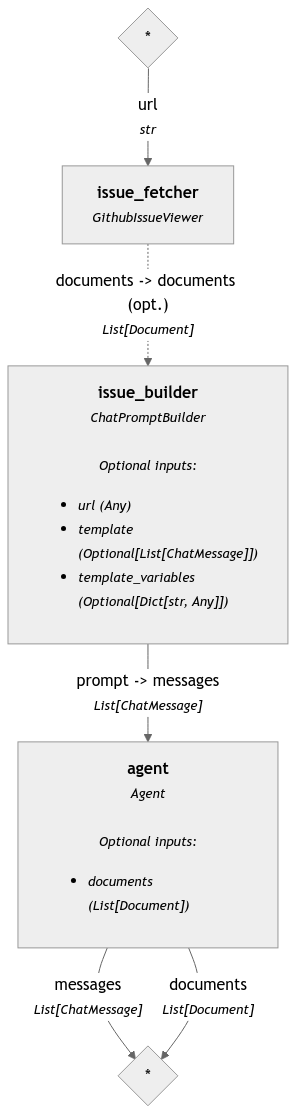

In [42]:
pp.show()

In [46]:
issue_url = "https://github.com/deepset-ai/haystack/issues/8836"

result = pp.run({"url": issue_url})

In [47]:
from IPython.display import display, Markdown
display(Markdown("# Comment from Agent\n\n" + result["agent"]["messages"][-1].tool_call_result.result))

# Comment from Agent

Thank you for reporting this issue. I can help explain the problem and provide several solutions.

# Problem Explanation
The issue occurs because NLTK attempts to download the `punkt_tab` tokenizer data at runtime when using `DocumentSplitter` with either:
- `split_by='sentence'`
- `split_by='word'` with `respect_sentence_boundary=True`

Since AWS Lambda provides a read-only filesystem, NLTK cannot download and save these files during execution.

# Solutions

## Option 1: Pre-Download NLTK Data in Docker Build
If you want to keep using sentence-based splitting, you can pre-download the NLTK data during your Docker image build. Add this to your Dockerfile:

```dockerfile
# Install NLTK data
RUN python -m pip install nltk
RUN python -c "import nltk; nltk.download('punkt_tab')"
```

The NLTK data will be installed in the Docker image at `/usr/local/share/nltk_data/`. Make sure to set the `NLTK_DATA` environment variable in your Lambda function configuration:

```python
import os
os.environ['NLTK_DATA'] = '/usr/local/share/nltk_data/'
```

## Option 2: Use Alternative Splitting Method
As mentioned in the comments, if you don't strictly need NLTK's sentence tokenization, you can use `split_by='period'` which provides similar functionality without the NLTK dependency:

```python
splitter = DocumentSplitter(split_by='period')
```

This is the simplest solution if exact sentence boundary detection isn't critical for your use case.

## Option 3: Package NLTK Data with Lambda
If you're not using Docker, you can include the NLTK data directly in your Lambda deployment package:

1. Download the data locally:
```python
import nltk
nltk.download('punkt_tab')
```

2. Find the downloaded data (usually in `~/nltk_data/`)
3. Copy the `punkt_tab` directory into your Lambda function's package
4. Set `NLTK_DATA` environment variable to point to this location

# Long-term Fix
We should consider either:
1. Making NLTK data downloads optional with a fallback to simpler splitting methods
2. Better documenting these infrastructure requirements
3. Providing a way to disable NLTK downloads and use pre-packaged data

Would you like me to create a separate issue to track these improvements?

In [48]:
for document in result["agent"]["documents"]:
    if document.meta["type"] in ["file_content"]:
        display(Markdown(f"[{document.meta['url']}]({document.meta['url']})"))

[https://github.com/deepset-ai/haystack/blob/main/haystack/components/preprocessors/document_splitter.py](https://github.com/deepset-ai/haystack/blob/main/haystack/components/preprocessors/document_splitter.py)

[https://github.com/deepset-ai/haystack/blob/main/haystack/components/preprocessors/sentence_tokenizer.py](https://github.com/deepset-ai/haystack/blob/main/haystack/components/preprocessors/sentence_tokenizer.py)

# From Agent to Multi-Agent

Let's make this agent a little more powerful.
We will pass the issue comments and the generated proposal to a second agent.
We also fork the original repository so that we can make edits.

The `Agent` will then:
* view relevant files
* perform edits commit by commit
* return a PR title and description once it is ready to go

In [ ]:
from github_components.repository_forker import GithubRepoForker
from github_components.file_editor import GithubFileEditor

